In [72]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ReduceLROnPlateau
import ipywidgets as widgets
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from IPython.display import display, clear_output
import os

In [73]:
train_dir = 'chest/train'
val_dir = 'chest/val'
test_dir = 'chest/test'

# Buat image data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [74]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(256, activation='relu'), # Kurangi neuron dari 512 menjadi 256
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

d:\project ngoding\fullstack pneumonia app detect\model\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [75]:
# Mengompilasi model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [76]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(
    train_generator,
    epochs=50, 
    validation_data=validation_generator,
    callbacks=[learning_rate_reduction, early_stopping]
)

d:\project ngoding\fullstack pneumonia app detect\model\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 460ms/step - accuracy: 0.8217 - loss: 0.4610 - val_accuracy: 0.5000 - val_loss: 1.3332 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 477ms/step - accuracy: 0.8901 - loss: 0.2797 - val_accuracy: 0.4375 - val_loss: 2.0477 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 460ms/step - accuracy: 0.9041 - loss: 0.2410 - val_accuracy: 0.5000 - val_loss: 1.3818 - learning_rate: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8872 - loss: 0.2756
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 472ms/step - accuracy: 0.8959 - loss: 0.2612 - val_accuracy: 0.5000 - val_loss: 7.6064 - learning_rate: 0.0010
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 496ms/step - accuracy: 0.9229 - loss: 0.1982 - val_accuracy: 0.7500 - val_loss: 0.4955 - learning_rate: 5.0000e-04
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 501ms/step - accuracy: 0

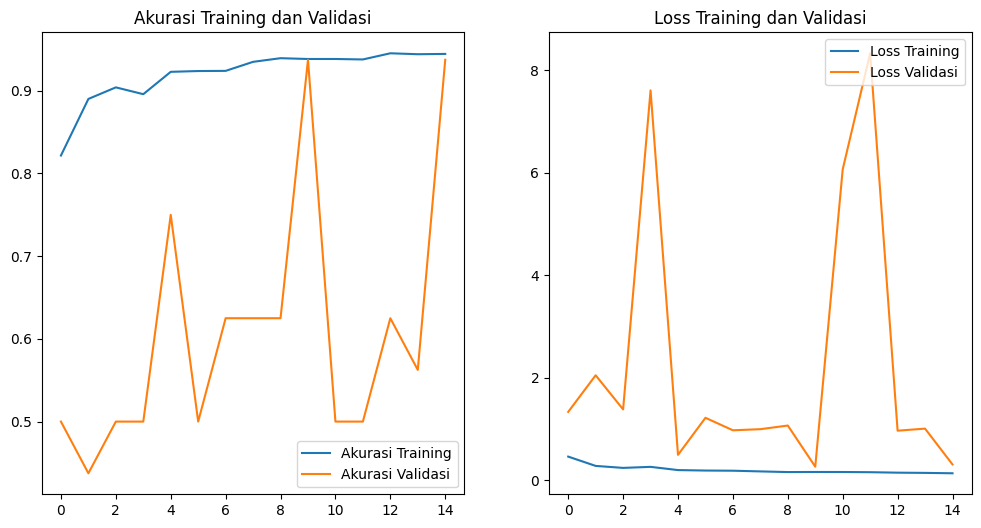

In [77]:
# nilai akurasi dan loss dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# plot untuk Akurasi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Akurasi Training')
plt.plot(epochs_range, val_acc, label='Akurasi Validasi')
plt.legend(loc='lower right')
plt.title('Akurasi Training dan Validasi')

# plot untuk Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss Training')
plt.plot(epochs_range, val_loss, label='Loss Validasi')
plt.legend(loc='upper right')
plt.title('Loss Training dan Validasi')
plt.show()

In [81]:
def predict_image(img_path):
    """Fungsi untuk memprediksi gambar tunggal."""

    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = x / 255.0

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    
    print(f"File: {img_path}")
    print(f"Nilai Prediksi: {classes[0][0]}")
    
    if classes[0] > 0.5:
        print("Hasil: Terdeteksi PNEUMONIA")
    else:
        print("Hasil: NORMAL")


try:
    predict_image('chest/test/PNEUMONIA/person3_virus_17.jpeg')
    print("-" * 30)
    predict_image('chest/test/NORMAL/IM-0059-0001.jpeg')
except FileNotFoundError:
    print("\nPastikan path file gambar sudah benar!")
    print("Misalnya: 'chest/test/NORMAL/nama_file.jpeg'")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
File: chest/test/PNEUMONIA/person3_virus_17.jpeg
Nilai Prediksi: 0.8589566946029663
Hasil: Terdeteksi PNEUMONIA
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
File: chest/test/NORMAL/IM-0059-0001.jpeg
Nilai Prediksi: 0.02183488942682743
Hasil: NORMAL
